<a href="https://colab.research.google.com/github/Hikaros/ML-Forex-Time-Series-Predictions/blob/master/Copy_of_Price%2C_RSI%2C_ATR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
!ls
# !rm  XAUUSD1440.csv

Saving Convert_Series_To_Supervised_Learning.py to Convert_Series_To_Supervised_Learning (1).py
Saving EURUSD.csv to EURUSD (1).csv
Saving GBP_USD Historical Data.csv to GBP_USD Historical Data (1).csv
Saving Hikaros_forex_functions.py to Hikaros_forex_functions (1).py
Saving technical_indicators.py to technical_indicators (1).py
Saving US Dollar Index Historical Data.csv to US Dollar Index Historical Data (1).csv
Saving USD_CHF Historical Data.csv to USD_CHF Historical Data (1).csv
'Convert_Series_To_Supervised_Learning (1).py'
 Convert_Series_To_Supervised_Learning.py
'EURUSD (1).csv'
 EURUSD.csv
'GBP_USD Historical Data (1).csv'
'GBP_USD Historical Data.csv'
'Hikaros_forex_functions (1).py'
 Hikaros_forex_functions.py
 __pycache__
 sample_data
'technical_indicators (1).py'
 technical_indicators.py
'USD_CHF Historical Data (1).csv'
'USD_CHF Historical Data.csv'
'US Dollar Index Historical Data (1).csv'
'US Dollar Index Historical Data.csv'


In [0]:
import math
import os
import numpy as np
import pandas as pd
from Hikaros_forex_functions import dukascopy_data_man
from Convert_Series_To_Supervised_Learning import series_to_supervised
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.signal import argrelextrema
from keras.layers import Embedding
from pandas import DataFrame
from pandas import read_csv
from datetime import datetime
from technical_indicators import relative_strength_index
from technical_indicators import average_true_range
from technical_indicators import macd
from technical_indicators import exponential_moving_average
from technical_indicators import bollinger_bands
from technical_indicators import  moving_average


In [0]:
# Dataset
dataset = read_csv("EURUSD.csv")

# Create Technical indicators
dataset["RSI"]=relative_strength_index(dataset,14)["RSI_14"]
dataset["ATR"] = average_true_range(dataset,14)["ATR_14"]
dataset[["macd1","macd2","macd3"]] = macd(dataset,12,26)[["MACD_12_26","MACDsign_12_26","MACDdiff_12_26"]]
dataset = moving_average(dataset,7)
dataset = moving_average(dataset,21)
# dataset= exponential_moving_average(dataset,7)
# dataset = exponential_moving_average(dataset,21)
# dataset = exponential_moving_average(dataset,50)
# dataset = exponential_moving_average(dataset,100)
dataset = exponential_moving_average(dataset,200)
dataset["STD_20"]=dataset["Close"].rolling(20).std()
dataset['upper_band'] = dataset['MA_21'] + (dataset['STD_20']*2)
dataset['lower_band'] = dataset['MA_21'] - (dataset['STD_20']*2)

# index Date
dataset["Date"]=pd.to_datetime(dataset["Date"],format="%Y.%m.%d")
dataset = dataset.set_index(dataset["Date"])
dataset.drop(["Date","Open","High","Low"],axis=1,inplace=True)
# dataset.drop(["Date"],axis=1,inplace=True)

# # Fill zeros
dataset["ATR"].fillna(method="bfill", inplace=True)
dataset["macd1"].fillna(method="bfill", inplace=True)
dataset["macd2"].fillna(method="bfill", inplace=True)
dataset["macd3"].fillna(method="bfill", inplace=True)
dataset['RSI'].fillna(method="bfill", inplace=True)
dataset["MA_7"].fillna(method="bfill", inplace=True)
dataset["MA_21"].fillna(method="bfill", inplace=True)
# dataset["EMA_7"].fillna(method="bfill", inplace=True)
# dataset["EMA_21"].fillna(method="bfill", inplace=True)
# dataset["EMA_50"].fillna(method="bfill", inplace=True)
# dataset["EMA_100"].fillna(method="bfill", inplace=True)
dataset["EMA_200"].fillna(method="bfill", inplace=True)
dataset["upper_band"].fillna(method="bfill", inplace=True)
dataset["lower_band"].fillna(method="bfill", inplace=True)
dataset["STD_20"].fillna(method="bfill", inplace=True)

dataset

,Close,RSI,ATR,macd1,macd2,macd3,MA_7,MA_21,EMA_200,STD_20,upper_band,lower_band
Date,,,,,,,,,,,,
1990-01-01,1.14260,0.335846,0.014295,0.003817,0.003014,-0.001377,1.157414,1.154990,1.207965,0.011580,1.177410,1.132571
1990-01-02,1.13090,0.335846,0.014295,0.003817,0.003014,-0.001377,1.157414,1.154990,1.207965,0.011580,1.177410,1.132571
1990-01-03,1.16720,0.335846,0.014295,0.003817,0.003014,-0.001377,1.157414,1.154990,1.207965,0.011580,1.177410,1.132571
1990-01-04,1.15920,0.335846,0.014295,0.003817,0.003014,-0.001377,1.157414,1.154990,1.207965,0.011580,1.177410,1.132571
1990-01-07,1.17240,0.335846,0.014295,0.003817,0.003014,-0.001377,1.157414,1.154990,1.207965,0.011580,1.177410,1.132571
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,1.12154,0.867247,0.003936,0.002771,0.001820,0.000951,1.114840,1.112184,1.113772,0.004664,1.121512,1.102856
2020-01-02,1.11712,0.700157,0.004103,0.002769,0.002009,0.000759,1.116003,1.112716,1.113806,0.004485,1.121685,1.103746
2020-01-03,1.11564,0.563211,0.004285,0.002618,0.002131,0.000487,1.117021,1.113189,1.113824,0.004236,1.121660,1.104717


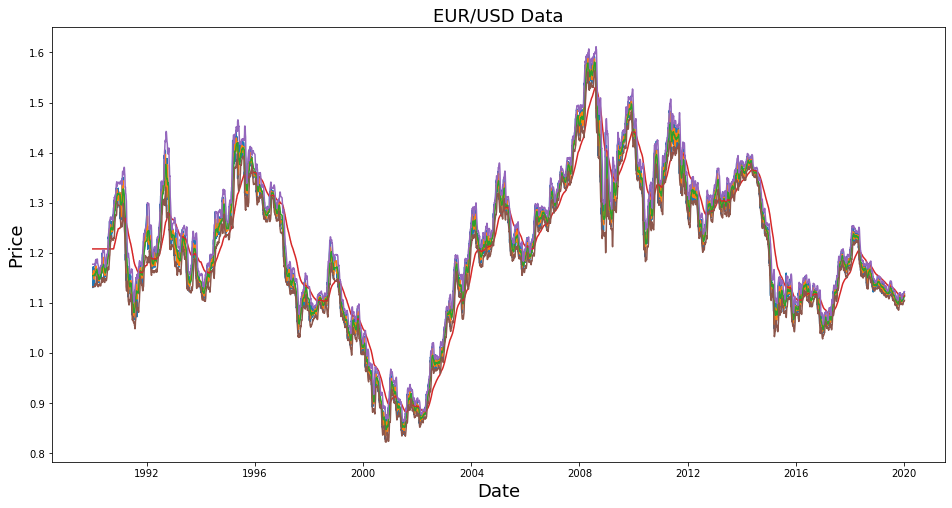

In [0]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('EUR/USD Data', fontsize=18)
plt.plot(dataset.drop(["RSI","ATR","macd1","macd2","macd3","STD_20"],axis=1))
# plt.plot(dataset[["Open","High"]])
# plt.plot(dataset["GOLD"]*0.001)
# plt.plot(dataset["RSI"]*0.2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [0]:
dataset.shape

(8777, 14)

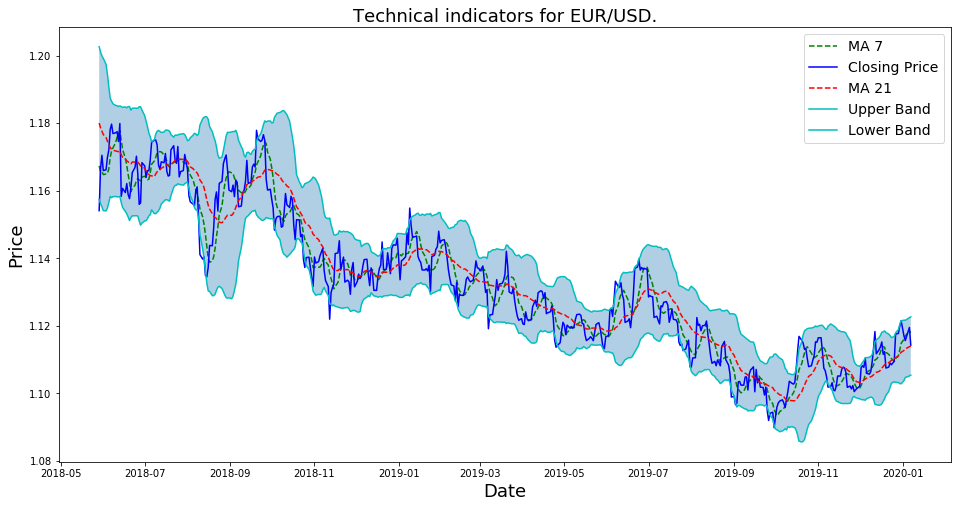

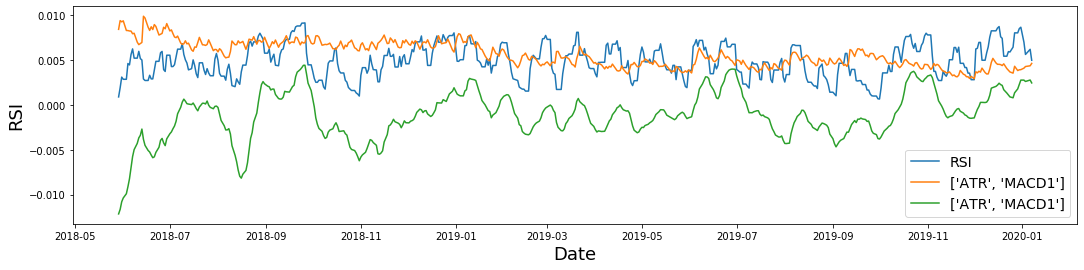

In [0]:
# Plot first subplot
datasetplot = dataset.iloc[-500:, :]
plt.figure(figsize=(16, 8))
x_ = range(3, datasetplot.shape[0])
x_ =list(datasetplot.index)

plt.plot(datasetplot['MA_7'],label='MA 7', color='g',linestyle='--')
plt.plot(datasetplot['Close'],label='Closing Price', color='b')
plt.plot(datasetplot['MA_21'],label='MA 21', color='r',linestyle='--')
plt.plot(datasetplot['upper_band'],label='Upper Band', color='c')
plt.plot(datasetplot['lower_band'],label='Lower Band', color='c')
plt.fill_between(x_, datasetplot['lower_band'], datasetplot['upper_band'], alpha=0.35)
# plt.plot(datasetplot['RSI']*0.05+1,label='RSI')
plt.title('Technical indicators for EUR/USD.',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.legend(fontsize=14)

plt.figure(figsize=(18,4))
# plt.title('MACD',fontsize=18)
plt.plot(datasetplot['RSI']*0.01,label='RSI')
plt.plot(datasetplot[["ATR","macd1"]],label=["ATR","MACD1"])
# plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
# plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
# plt.plot(datasetplot['log_momentum'],label='Momentum', color='b',linestyle='-')
plt.ylabel('RSI',fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [0]:
# #Create a new dataframe with only the 'Close column
# data = dataset.filter(["Close"])
# #Create a new dataframe with only the 'RSI column
# RSI = dataset.filter(["RSI"])
n_features = dataset.shape[1]

# #Convert the dataframe to a numpy array
# price = data.values
# RSI = RSI.values
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# drop columns we don't want to predict
reframed.drop(reframed.columns[-n_features+1:], axis=1, inplace=True)
print(reframed)
reframed.shape


      var1(t-1)  var2(t-1)  var3(t-1)  ...  var10(t)  var11(t)  var12(t)
1      0.408890   0.319149   0.380185  ...  0.156180  0.419215  0.418355
2      0.393683   0.319149   0.380185  ...  0.156180  0.419215  0.418355
3      0.440863   0.319149   0.380185  ...  0.156180  0.419215  0.418355
4      0.430465   0.319149   0.380185  ...  0.156180  0.419215  0.418355
5      0.447621   0.319149   0.380185  ...  0.156180  0.419215  0.418355
...         ...        ...        ...  ...       ...       ...       ...
8772   0.379465   0.862825   0.033473  ...  0.038706  0.344410  0.378239
8773   0.381518   0.880017   0.034061  ...  0.035660  0.344642  0.379441
8774   0.375773   0.703661   0.039649  ...  0.031434  0.344609  0.380751
8775   0.373850   0.559122   0.045739  ...  0.032790  0.345656  0.381376
8776   0.378906   0.619480   0.048478  ...  0.032734  0.345965  0.381706

[8776 rows x 24 columns]
      var1(t-1)  var2(t-1)  var3(t-1)  ...  var11(t-1)  var12(t-1)   var1(t)
1      0.408890   0.3

(8776, 13)

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = int(values.shape[0]/8776*7000)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7000, 1, 16) (7000,) (1776, 1, 16) (1776,)


In [0]:
# design network
model = Sequential()
model.add(Dense(128,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Conv1D(filters = 80, kernel_size= 1,padding='same', activation='relu', kernel_initializer="glorot_uniform"))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters = 48,kernel_size = 1,padding='same', activation='relu', kernel_initializer="glorot_uniform"))
# model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
# model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, kernel_initializer="uniform"))

In [0]:
# # design network
# model = Sequential()
# model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(100, return_sequences= False))
# model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 128)            2176      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 80)             10320     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 48)             3888      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)             10368     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 35,105
Trainable params: 35,105
Non-trainable params: 0
__________________________________________________

In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7000 samples, validate on 1776 samples
Epoch 1/100
 - 3s - loss: 0.0836 - val_loss: 0.0550
Epoch 2/100
 - 1s - loss: 0.0274 - val_loss: 0.0746
Epoch 3/100
 - 1s - loss: 0.0238 - val_loss: 0.0705
Epoch 4/100
 - 1s - loss: 0.0153 - val_loss: 0.0708
Epoch 5/100
 - 1s - loss: 0.0183 - val_loss: 0.0744
Epoch 6/100
 - 1s - loss: 0.0221 - val_loss: 0.0741
Epoch 7/100
 - 1s - loss: 0.0145 - val_loss: 0.0615
Epoch 8/100
 - 1s - loss: 0.0131 - val_loss: 0.0507
Epoch 9/100
 - 1s - loss: 0.0123 - val_loss: 0.0487
Epoch 10/100
 - 1s - loss: 0.0123 - val_loss: 0.0470
Epoch 11/100
 - 1s - loss: 0.0115 - val_loss: 0.0393
Epoch 12/100
 - 1s - loss: 0.0105 - val_loss: 0.0287
Epoch 13/100
 - 1s - loss: 0.0090 - val_loss: 0.0114
Epoch 14/100
 - 1s - loss: 0.0067 - val_loss: 0.0031
Epoch 15/100
 - 1s - loss: 0.0034 - val_loss: 0.0023
Epoch 16/100
 - 1s - loss: 0.0019 - val_loss: 8.8643e-04
Epoch 17/100
 - 1s - loss: 0.0013 - val_loss: 4.1691e-04
Epoch 18/100
 - 1s - loss: 0.0011 - val_loss: 4.9430

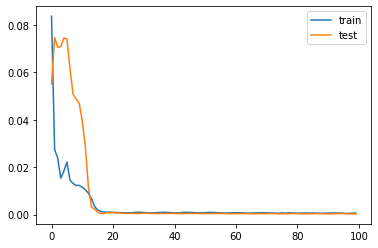

In [0]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
test_X, y_test = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y)
print(inv_y.shape)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[1.3572881 1.3574259 1.3614314 ... 1.1176686 1.1119998 1.1159222]
[1.38068 1.38167 1.38302 ... 1.11564 1.11953 1.11429]
(1776,)
Test RMSE: 0.013


(1776, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


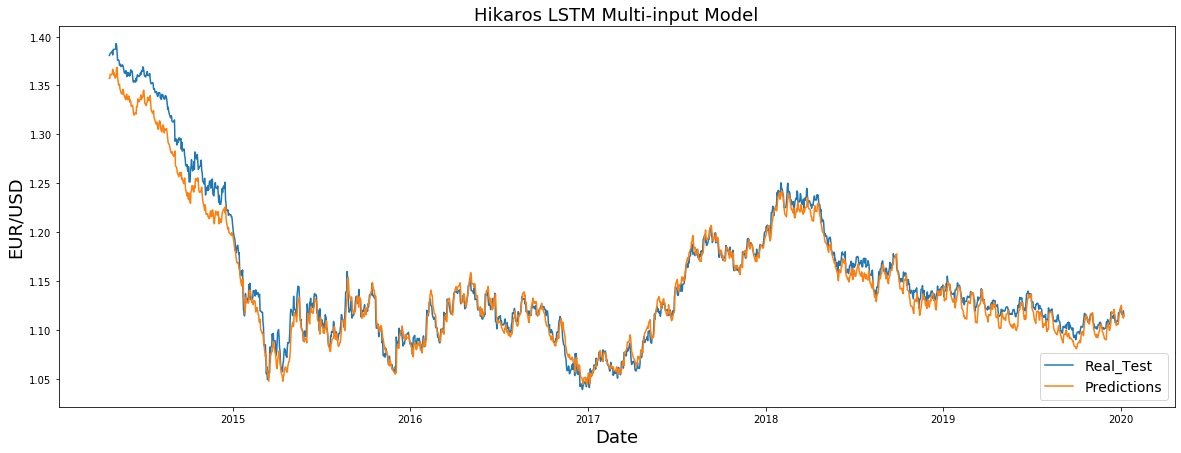

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[1:n_train_hours]
valid = data[n_train_hours+1:]
print(valid.shape)
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_Test", 'Predictions'], loc='lower right' , fontsize=14)
plt.show()

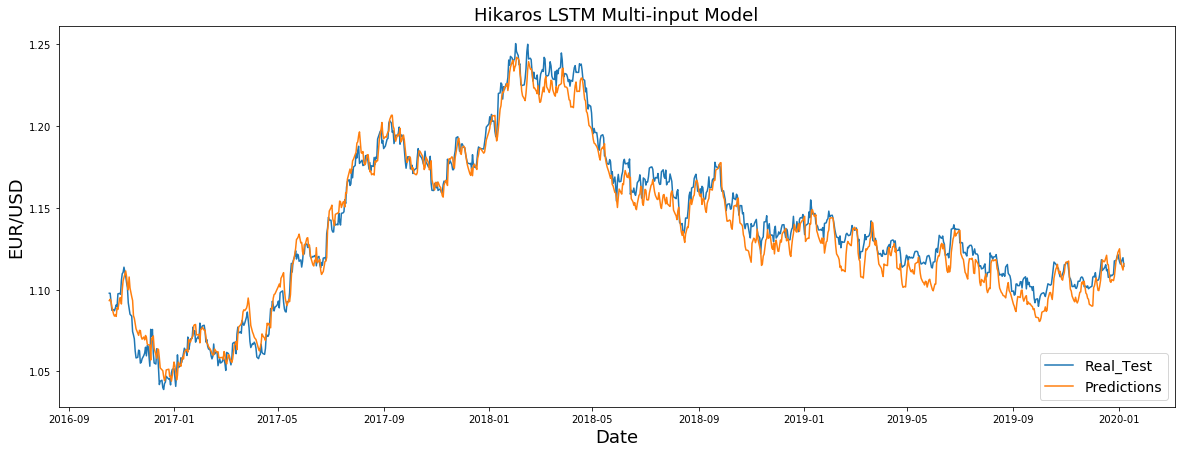

In [0]:
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]][-1000:])
plt.legend(["Real_Test", 'Predictions'], loc='lower right',fontsize=14)
plt.show()

(1776, 1)
(1776,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


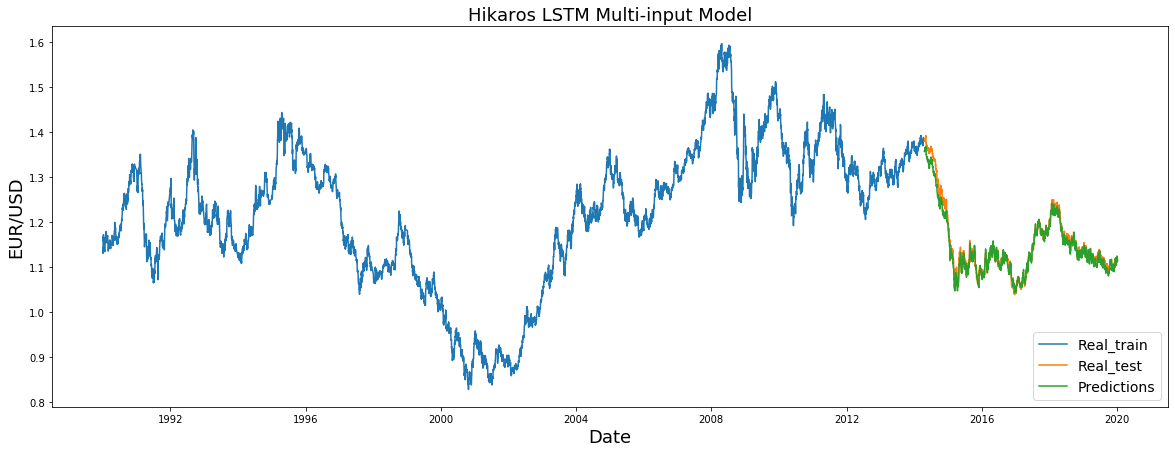

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[:n_train_hours]
valid = data[n_train_hours+1:]
print(valid.shape)
print(inv_yhat.shape)
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(20,7))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_train",'Real_test', 'Predictions'], loc='lower right', fontsize=14)
plt.show()